LLMs vs True Outcome
                   accuracy  precision  recall     f1    auc    mse    mae
GPT-4o (prompt 5)     0.667      0.636   0.538  0.583  0.652  0.333  0.333
GPT-4o (prompt 6)     0.467      0.448   1.000  0.619  0.529  0.533  0.533
Qwen (prompt 5)       0.567      0.500   0.846  0.629  0.600  0.433  0.433
Qwen (prompt 6)       0.467      0.440   0.846  0.579  0.511  0.533  0.533
Gemini (prompt 5)     0.567      0.500   0.846  0.629  0.600  0.433  0.433
Gemini (prompt 6)     0.500      0.458   0.846  0.595  0.541  0.500  0.500

Individual Human Predictions vs True Outcome
                          accuracy  precision  recall     f1    auc    mse  \
Average Individual Human     0.621      0.575   0.599  0.579  0.619  0.379   

                            mae  
Average Individual Human  0.379  

Distribution of individual human accuracy:
Min: 0.500, Max: 0.733, Mean: 0.621, Median: 0.633

LLMs vs Individual Human Predictions
                   accuracy  precision  recall    

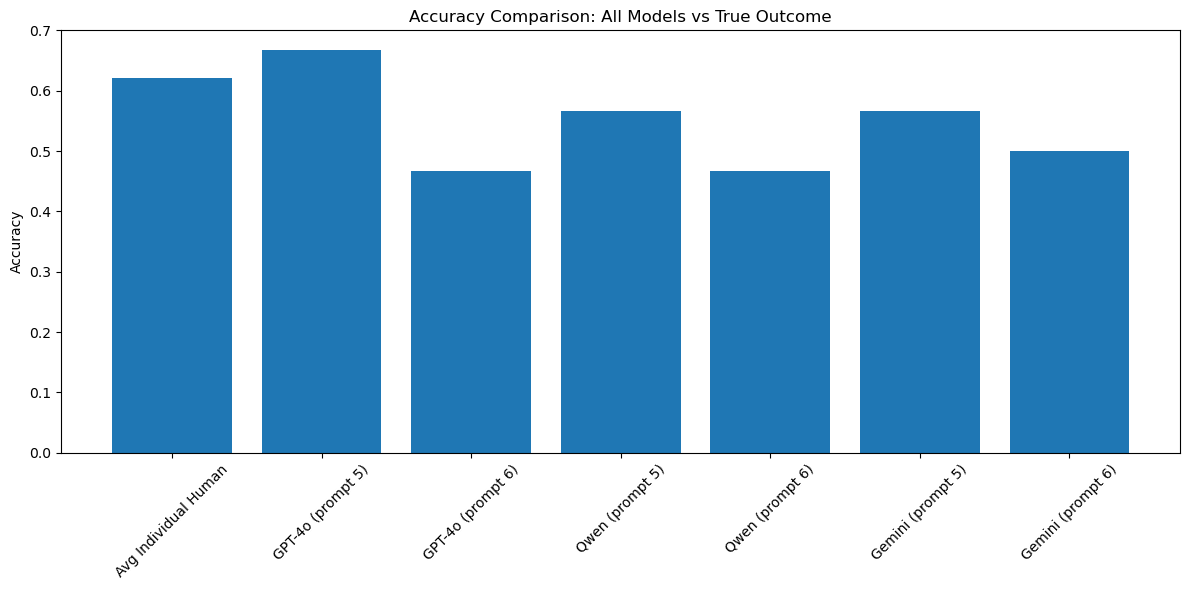

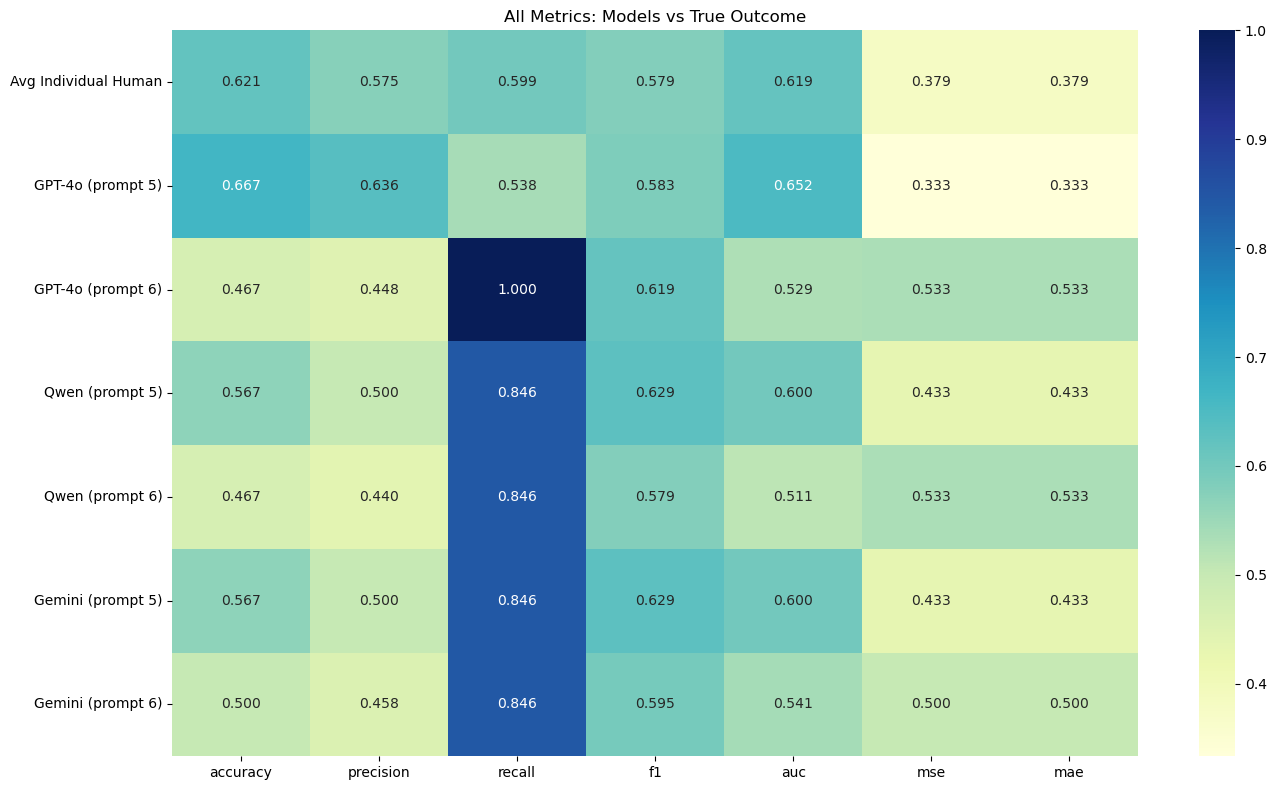

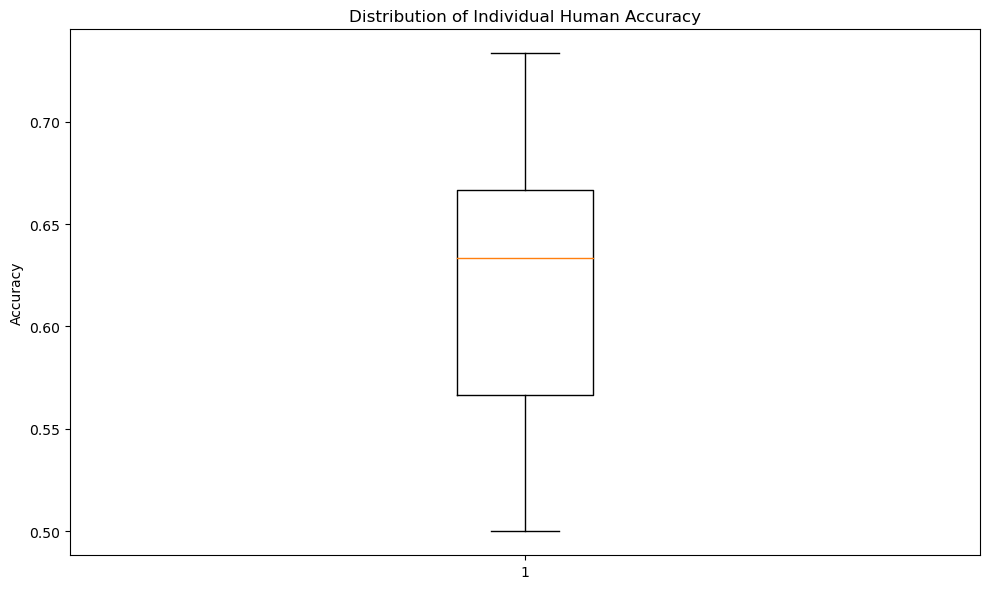

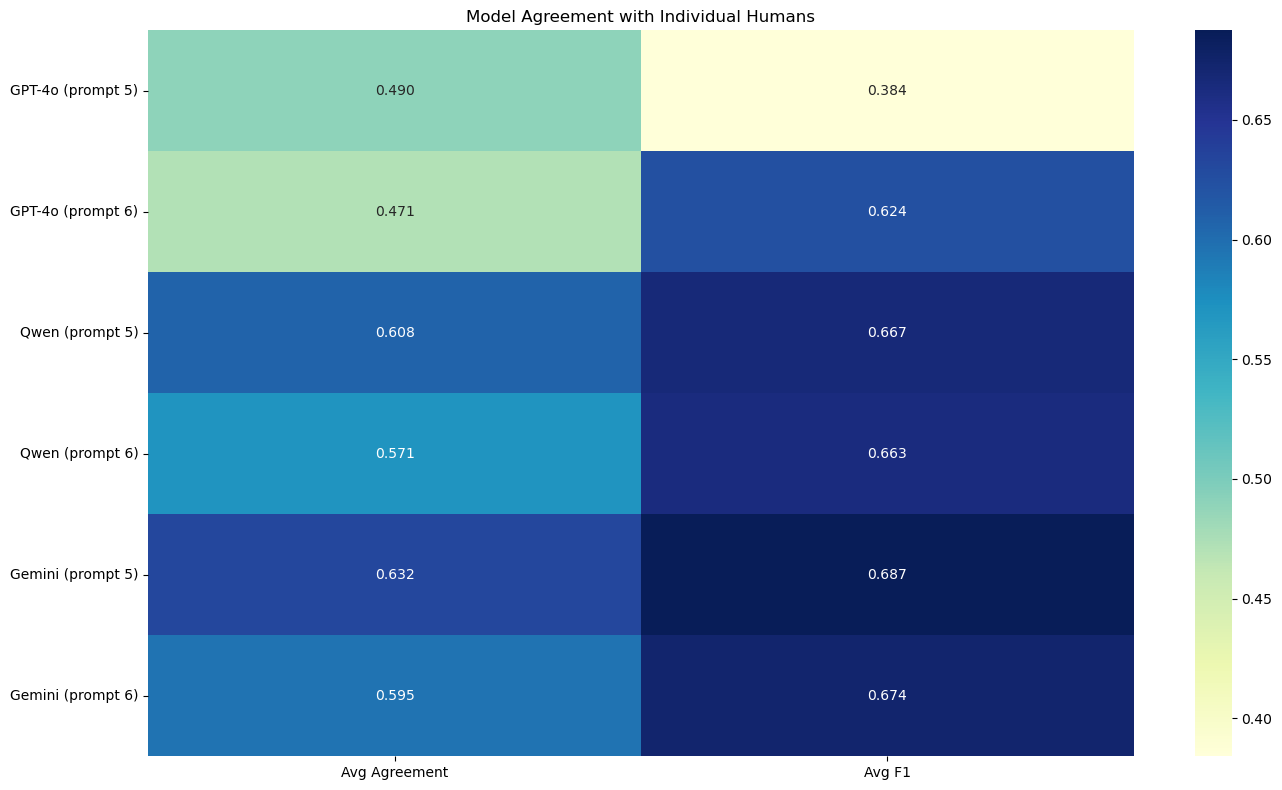

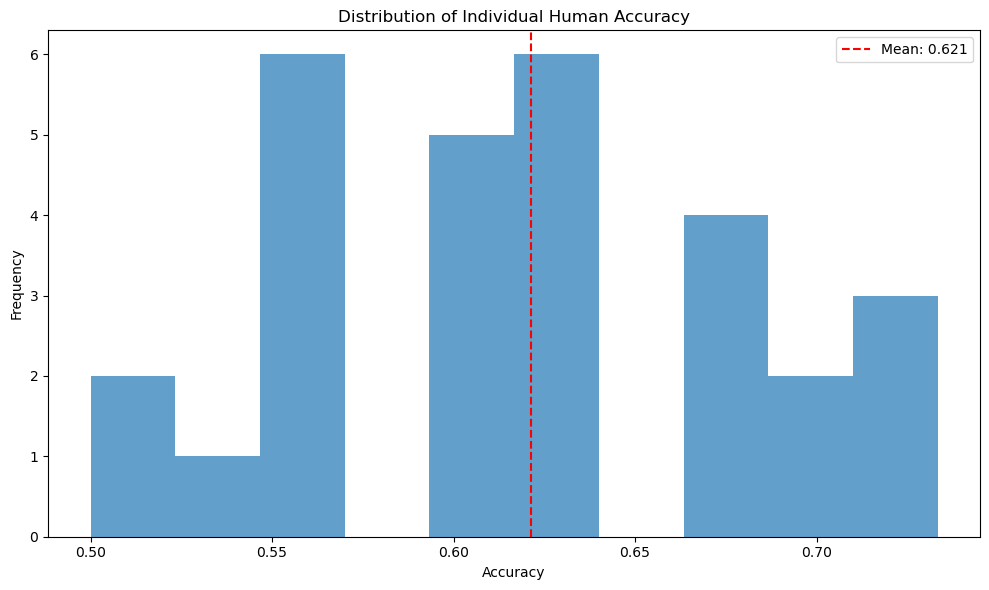

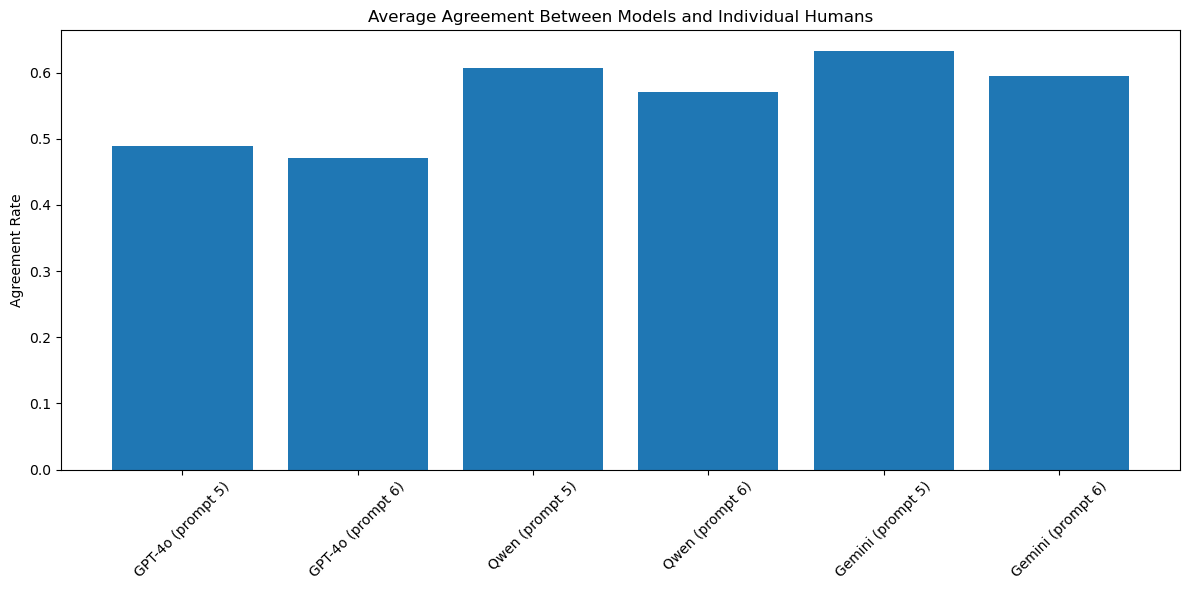

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Load the data
df = pd.read_csv('./dataset/analyze-predictions.csv')
human_df = pd.read_csv('./dataset/badidea_ground_truth.csv')

# Define a function to convert continuous predictions to binary (using 0.5 as threshold)
def to_binary(series, threshold=0.5):
    # Check if input is numpy array or pandas Series
    if isinstance(series, np.ndarray):
        unique_values = set(np.unique(series))
    else:
        unique_values = set(series.unique())
        
    # Check if the series already contains only 0s and 1s
    if unique_values.issubset({0, 1}) or unique_values.issubset({0.0, 1.0}):
        return series.astype(int)  # Already binary, just ensure int type
    
    # For continuous values, convert to binary based on threshold
    return (series >= threshold).astype(int)

# Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred_prob):
    y_pred = to_binary(y_pred_prob)
    
    # Handle cases where only one class is present
    try:
        auc = roc_auc_score(y_true, y_pred_prob)
    except:
        auc = np.nan
        
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'auc': auc,
        'mse': np.mean((y_true - y_pred_prob) ** 2),
        'mae': np.mean(np.abs(y_true - y_pred_prob))
    }
    return metrics

# ----- LLMs vs True Outcome (No change needed) -----
print("="*50)
print("LLMs vs True Outcome")
print("="*50)

# Define models and prompts
models = ['GPT-4o', 'Qwen', 'Gemini']
prompts = ['prompt 5', 'prompt 6']

# Calculate metrics for each model and prompt combination
metrics_vs_true = {}
for model in models:
    for prompt in prompts:
        col_name = f"{model} Prediction ({prompt})"
        metrics_vs_true[f"{model} ({prompt})"] = calculate_metrics(df['True Outcome'], df[col_name])

# Convert to DataFrame for easier comparison
metrics_df_vs_true = pd.DataFrame(metrics_vs_true).T
print(metrics_df_vs_true.round(3))

# ----- NEW: Individual Human Prediction vs True Outcome -----
print("\n" + "="*50)
print("Individual Human Predictions vs True Outcome")
print("="*50)

# Create a mapping from Question Mapping to True Outcome
question_to_outcome = dict(zip(df['Question Mapping'], df['True Outcome']))

# Get unique participant IDs
participant_ids = human_df['participant_id'].unique()

# Calculate metrics for each individual human participant
human_metrics = {}
for participant_id in participant_ids:
    # Get this participant's predictions
    participant_data = human_df[human_df['participant_id'] == participant_id]
    
    # Create lists to store true outcomes and participant predictions
    true_outcomes = []
    participant_predictions = []
    
    # Match participant responses with true outcomes
    for _, row in participant_data.iterrows():
        question_id = row['response_video']
        if question_id in question_to_outcome:
            true_outcomes.append(question_to_outcome[question_id])
            participant_predictions.append(row['class'])
    
    # Calculate metrics if this participant has matching predictions
    if len(true_outcomes) > 0:
        human_metrics[participant_id] = calculate_metrics(
            np.array(true_outcomes), 
            np.array(participant_predictions)
        )

# Calculate average metrics across all participants
avg_human_metrics = {}
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'mse', 'mae']:
    values = [m[metric] for m in human_metrics.values() if not np.isnan(m[metric])]
    avg_human_metrics[metric] = np.mean(values) if values else np.nan

# Display average human performance
human_df_metrics = pd.DataFrame(avg_human_metrics, index=['Average Individual Human'])
print(human_df_metrics.round(3))

# Also show distribution of human performance
print("\nDistribution of individual human accuracy:")
human_accuracies = [metrics['accuracy'] for metrics in human_metrics.values()]
print(f"Min: {min(human_accuracies):.3f}, Max: {max(human_accuracies):.3f}, Mean: {np.mean(human_accuracies):.3f}, Median: {np.median(human_accuracies):.3f}")

# ----- NEW: LLMs vs Individual Human Predictions -----
print("\n" + "="*50)
print("LLMs vs Individual Human Predictions")
print("="*50)

# Create a mapping from Question Mapping to LLM predictions
question_to_llm = {}
for model in models:
    for prompt in prompts:
        col_name = f"{model} Prediction ({prompt})"
        question_to_llm[(model, prompt)] = dict(zip(df['Question Mapping'], df[col_name]))

# Calculate metrics for each model compared to each participant
llm_vs_human_metrics = {}
for model in models:
    for prompt in prompts:
        model_key = f"{model} ({prompt})"
        llm_vs_human_metrics[model_key] = {}
        
        for participant_id in participant_ids:
            # Get this participant's predictions
            participant_data = human_df[human_df['participant_id'] == participant_id]
            
            # Create lists to store participant predictions and LLM predictions
            human_preds = []
            llm_preds = []
            
            # Match participant responses with LLM predictions
            for _, row in participant_data.iterrows():
                question_id = row['response_video']
                if question_id in question_to_llm[(model, prompt)]:
                    human_preds.append(row['class'])
                    llm_preds.append(question_to_llm[(model, prompt)][question_id])
            
            # Calculate metrics if this participant has matching predictions
            if len(human_preds) > 0:
                llm_vs_human_metrics[model_key][participant_id] = calculate_metrics(
                    np.array(human_preds), 
                    np.array(llm_preds)
                )

# Calculate average metrics for each model vs humans
avg_llm_vs_human = {}
for model_key, participant_metrics in llm_vs_human_metrics.items():
    avg_llm_vs_human[model_key] = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'mse', 'mae']:
        values = [m[metric] for m in participant_metrics.values() if not np.isnan(m[metric])]
        avg_llm_vs_human[model_key][metric] = np.mean(values) if values else np.nan

# Convert to DataFrame for easier comparison
avg_llm_vs_human_df = pd.DataFrame(avg_llm_vs_human).T
print(avg_llm_vs_human_df.round(3))

# ----- Visualization -----
# Create a bar chart to compare accuracy of all models against true outcome
plt.figure(figsize=(12, 6))
accuracy_comparison = {
    'Avg Individual Human': avg_human_metrics['accuracy']
}

for model in models:
    for prompt in prompts:
        key = f"{model} ({prompt})"
        accuracy_comparison[key] = metrics_vs_true[key]['accuracy']

plt.bar(accuracy_comparison.keys(), accuracy_comparison.values())
plt.title('Accuracy Comparison: All Models vs True Outcome')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('accuracy_comparison.png')

# Create a heatmap to visualize all metrics for all models against true outcome
plt.figure(figsize=(14, 8))
metrics_df_combined = pd.concat([pd.DataFrame(avg_human_metrics, index=['Avg Individual Human']), metrics_df_vs_true])
sns.heatmap(metrics_df_combined, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('All Metrics: Models vs True Outcome')
plt.tight_layout()
plt.savefig('metrics_heatmap.png')

# Create a box plot to visualize distribution of human accuracies
plt.figure(figsize=(10, 6))
human_acc_data = [metrics['accuracy'] for metrics in human_metrics.values()]
plt.boxplot(human_acc_data)
plt.title('Distribution of Individual Human Accuracy')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('human_accuracy_distribution.png')

# Create a heatmap to visualize model agreement with individual humans
plt.figure(figsize=(14, 8))
model_human_agreement = pd.DataFrame(index=list(llm_vs_human_metrics.keys()))

# Calculate average agreement for each model
for model_key in llm_vs_human_metrics.keys():
    model_human_agreement.loc[model_key, 'Avg Agreement'] = np.mean(
        [metrics['accuracy'] for metrics in llm_vs_human_metrics[model_key].values()]
    )
    model_human_agreement.loc[model_key, 'Avg F1'] = np.mean(
        [metrics['f1'] for metrics in llm_vs_human_metrics[model_key].values()]
    )

sns.heatmap(model_human_agreement, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Agreement with Individual Humans')
plt.tight_layout()
plt.savefig('model_human_agreement.png')

# ----- Advanced Analysis -----
# Calculate agreement rate between models
print("\n" + "="*50)
print("Model Agreement Analysis")
print("="*50)

agreement_df = pd.DataFrame(index=models, columns=models)
for model1 in models:
    for model2 in models:
        if model1 == model2:
            agreement_df.loc[model1, model2] = 1.0
            continue
            
        # Calculate agreement rate for prompt 5
        pred1 = to_binary(df[f"{model1} Prediction (prompt 5)"])
        pred2 = to_binary(df[f"{model2} Prediction (prompt 5)"])
        agreement_rate = np.mean(pred1 == pred2)
        agreement_df.loc[model1, model2] = agreement_rate

print("Model Agreement Rate (prompt 5):")
print(agreement_df.round(3))

# ----- Per Video Analysis -----
print("\n" + "="*50)
print("Per Video Performance")
print("="*50)

# Calculate accuracy per video for each model
video_performance = pd.DataFrame(index=df['Video'].unique())

# Add average individual human performance per video
video_to_question = dict(zip(df['Video'], df['Question Mapping']))
video_performance['Avg Individual Human Accuracy'] = np.nan

for video in video_performance.index:
    question_id = video_to_question[video]
    true_outcome = question_to_outcome[question_id]
    
    # Get all human predictions for this question
    human_preds = human_df[human_df['response_video'] == question_id]['class']
    
    if len(human_preds) > 0:
        # Calculate accuracy for each human and average
        accuracies = []
        for pred in human_preds:
            accuracies.append(1 if pred == true_outcome else 0)
        
        video_performance.loc[video, 'Avg Individual Human Accuracy'] = np.mean(accuracies)

# Add model performances
for model in models:
    for prompt in prompts:
        col_name = f"{model} ({prompt}) Accuracy"
        video_performance[col_name] = [
            accuracy_score(
                df.loc[df['Video'] == video, 'True Outcome'], 
                df.loc[df['Video'] == video, f"{model} Prediction ({prompt})"]
            )
            for video in video_performance.index
        ]

# Top 5 hardest videos (lowest human accuracy)
print("Top 5 Hardest Videos (Lowest Human Accuracy):")
print(video_performance.sort_values('Avg Individual Human Accuracy').head(5))

# Top 5 easiest videos (highest human accuracy)
print("\nTop 5 Easiest Videos (Highest Human Accuracy):")
print(video_performance.sort_values('Avg Individual Human Accuracy', ascending=False).head(5))

# ----- Summary Statistics -----
print("\n" + "="*50)
print("Summary Statistics")
print("="*50)

# Calculate average accuracy across all videos
avg_acc = {
    'Avg Individual Human': video_performance['Avg Individual Human Accuracy'].mean()
}

for model in models:
    for prompt in prompts:
        avg_acc[f"{model} ({prompt})"] = video_performance[f"{model} ({prompt}) Accuracy"].mean()

# Print summary
for name, acc in avg_acc.items():
    print(f"{name}: Average Accuracy = {acc:.3f}")

# Count videos where each model outperforms humans
for model in models:
    for prompt in prompts:
        outperform_count = (video_performance[f"{model} ({prompt}) Accuracy"] > video_performance['Avg Individual Human Accuracy']).sum()
        total_videos = len(video_performance)
        print(f"{model} ({prompt}) outperforms humans on {outperform_count}/{total_videos} videos ({outperform_count/total_videos*100:.1f}%)")

# Create a histogram of human accuracies
plt.figure(figsize=(10, 6))
plt.hist(human_accuracies, bins=10, alpha=0.7)
plt.title('Distribution of Individual Human Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.axvline(x=np.mean(human_accuracies), color='r', linestyle='--', label=f'Mean: {np.mean(human_accuracies):.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('human_accuracy_histogram.png')

# Create a bar chart comparing model agreement with humans
plt.figure(figsize=(12, 6))
agreement_data = {k: model_human_agreement.loc[k, 'Avg Agreement'] for k in model_human_agreement.index}
plt.bar(agreement_data.keys(), agreement_data.values())
plt.title('Average Agreement Between Models and Individual Humans')
plt.ylabel('Agreement Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_human_agreement_chart.png')

In [8]:
print("\n" + "="*50)
print("Data Visualizations")
print("="*50)

# 1. Confusion matrices for each model vs true outcome
plt.figure(figsize=(18, 12))
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices: Models vs True Outcome', fontsize=16)

# Flatten for easier indexing if needed
axs = axs.flatten()

# Add human predictions (use individual human predictions)
# Get all human predictions for all questions
all_human_preds = []
all_true_outcomes = []

# Create a mapping from Question Mapping to True Outcome
question_to_outcome = dict(zip(df['Question Mapping'], df['True Outcome']))

# Collect all matching human predictions and true outcomes
for _, row in human_df.iterrows():
    question_id = row['response_video']
    if question_id in question_to_outcome:
        all_human_preds.append(row['class'])
        all_true_outcomes.append(question_to_outcome[question_id])

# Create confusion matrix from all individual human predictions
if all_human_preds:
    cm_human = confusion_matrix(all_true_outcomes, all_human_preds)
    sns.heatmap(cm_human, annot=True, fmt='d', cmap='Blues', ax=axs[0],
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    axs[0].set_title('Individual Human Predictions vs True Outcome')

# Add each model
i = 1
for model in models:
    for prompt in ['prompt 5']:  # Just use prompt 5 for simplicity
        col_name = f"{model} Prediction ({prompt})"
        cm = confusion_matrix(df['True Outcome'], df[col_name])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i],
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        axs[i].set_title(f'{model} ({prompt}) vs True Outcome')
        i += 1

# If there are empty subplots, hide them
if i < len(axs):
    for j in range(i, len(axs)):
        axs[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.savefig('confusion_matrices.png')
plt.close()

# 2. ROC curves
plt.figure(figsize=(10, 8))
from sklearn.metrics import roc_curve, auc

# For individual humans, we need to calculate a mean ROC curve
# First, let's collect all participant predictions and true outcomes
participant_predictions = []
for participant_id in participant_ids:
    # Get this participant's predictions
    participant_data = human_df[human_df['participant_id'] == participant_id]
    
    # Create lists to store true outcomes and participant predictions
    true_outcomes = []
    participant_preds = []
    
    # Match participant responses with true outcomes
    for _, row in participant_data.iterrows():
        question_id = row['response_video']
        if question_id in question_to_outcome:
            true_outcomes.append(question_to_outcome[question_id])
            participant_preds.append(row['class'])
    
    if true_outcomes:
        participant_predictions.append((true_outcomes, participant_preds))

# Calculate and plot ROC curve for models
for model in models:
    for prompt in prompts:
        col_name = f"{model} Prediction ({prompt})"
        try:
            fpr, tpr, _ = roc_curve(df['True Outcome'], df[col_name])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model} ({prompt}) (AUC = {roc_auc:.3f})')
        except:
            print(f"Couldn't create ROC curve for {model} ({prompt}) - possibly binary predictions only")

# Plot average human AUC (from previously calculated metrics)
if 'auc' in avg_human_metrics and not np.isnan(avg_human_metrics['auc']):
    # If we have many participants, plot a representative ROC curve
    if participant_predictions:
        # Use the first participant with enough data for a simple visual
        for true_outcomes, participant_preds in participant_predictions:
            try:
                fpr, tpr, _ = roc_curve(true_outcomes, participant_preds)
                # Only plot if we get a valid curve
                if len(fpr) > 1:
                    plt.plot(fpr, tpr, 'b--', alpha=0.3)  # Plot with low opacity
            except:
                continue
    
    # Add a label for the average human AUC
    plt.plot([0, 1], [0, 1], 'b-', label=f'Avg Individual Human (AUC = {avg_human_metrics["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Models vs True Outcome')
plt.legend(loc="lower right")
plt.savefig('roc_curves.png')
plt.close()

# 3. Model and Human Agreement Matrix
# Create a new approach focused on LLMs and aggregated human metrics
plt.figure(figsize=(14, 12))

# Define the entities we want to compare
entities = ['Avg Individual Human', 'True Outcome']
for model in models:
    for prompt in prompts:
        entities.append(f"{model} ({prompt})")

# Create the matrix
agreement_matrix = np.ones((len(entities), len(entities)))

# Fill in True Outcome vs Humans
agreement_matrix[0, 1] = avg_human_metrics['accuracy']
agreement_matrix[1, 0] = avg_human_metrics['accuracy']

# Fill in True Outcome vs Models
for i, model_key in enumerate(metrics_vs_true.keys()):
    agreement_matrix[1, i+2] = metrics_vs_true[model_key]['accuracy']
    agreement_matrix[i+2, 1] = metrics_vs_true[model_key]['accuracy']

# Fill in Human vs Models
for i, model_key in enumerate(avg_llm_vs_human.keys()):
    agreement_matrix[0, i+2] = avg_llm_vs_human[model_key]['accuracy']
    agreement_matrix[i+2, 0] = avg_llm_vs_human[model_key]['accuracy']

# Fill in Model vs Model
for i, model_key1 in enumerate(metrics_vs_true.keys()):
    for j, model_key2 in enumerate(metrics_vs_true.keys()):
        if i != j:
            # Extract model and prompt
            model1, prompt1 = model_key1.replace(')', '').split(' (')
            model2, prompt2 = model_key2.replace(')', '').split(' (')
            
            # Get predictions
            pred1 = df[f"{model1} Prediction ({prompt1})"]
            pred2 = df[f"{model2} Prediction ({prompt2})"]
            
            # Calculate agreement
            agreement_matrix[i+2, j+2] = np.mean(pred1 == pred2)

# Create heatmap
sns.heatmap(agreement_matrix, annot=True, cmap='YlGnBu', 
            xticklabels=entities,
            yticklabels=entities,
            fmt='.3f')
plt.title('Agreement Matrix Between Predictions')
plt.tight_layout()
plt.savefig('agreement_matrix.png')
plt.close()

# 4. Per-video performance comparison
plt.figure(figsize=(20, 10))
# Sort videos by human performance for better visualization
sorted_videos = video_performance.sort_values('Avg Individual Human Accuracy').index.tolist()
video_performance_sorted = video_performance.loc[sorted_videos]

# Plot performance for each video
plt.figure(figsize=(20, 10))
video_performance_sorted.plot(kind='bar', figsize=(20, 10))
plt.title('Performance by Video: Individual Humans vs LLMs')
plt.xlabel('Video')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('video_performance.png')
plt.close()

# 5. Distribution of individual human accuracy values
plt.figure(figsize=(10, 6))
human_accuracies = [metrics['accuracy'] for metrics in human_metrics.values()]
plt.hist(human_accuracies, bins=10, alpha=0.7)
plt.axvline(x=np.mean(human_accuracies), color='r', linestyle='--', 
            label=f'Mean: {np.mean(human_accuracies):.3f}')
plt.title('Distribution of Individual Human Accuracy Values')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('human_accuracy_distribution.png')
plt.close()

# 6. Create box plots to show variance in predictions across models
plt.figure(figsize=(12, 8))
accuracy_data = []
labels = []

# Create a list of per-video accuracy for humans
human_per_video_acc = []
for video in video_performance.index:
    if not np.isnan(video_performance.loc[video, 'Avg Individual Human Accuracy']):
        human_per_video_acc.append(video_performance.loc[video, 'Avg Individual Human Accuracy'])

# Add human data
accuracy_data.append(human_per_video_acc)
labels.append('Avg Individual Human')

# Add model data
for model in models:
    for prompt in prompts:
        accuracy_data.append(video_performance[f"{model} ({prompt}) Accuracy"])
        labels.append(f"{model} ({prompt})")

plt.boxplot(accuracy_data, labels=labels)
plt.title('Distribution of Accuracy Across Videos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_distribution.png')
plt.close()

# 7. NEW: Inter-participant agreement
# Calculate and visualize how much humans agree with each other
if len(participant_ids) > 1:
    plt.figure(figsize=(12, 10))
    
    # Create a matrix of participant agreements
    human_agreement = np.ones((len(participant_ids), len(participant_ids)))
    
    # Calculate agreement between every pair of participants
    for i, pid1 in enumerate(participant_ids):
        for j, pid2 in enumerate(participant_ids):
            if i != j:
                # Get predictions from both participants
                pred1 = {}
                pred2 = {}
                
                # Build dictionaries of question_id -> prediction for each participant
                for _, row in human_df[human_df['participant_id'] == pid1].iterrows():
                    pred1[row['response_video']] = row['class']
                
                for _, row in human_df[human_df['participant_id'] == pid2].iterrows():
                    pred2[row['response_video']] = row['class']
                
                # Find common questions
                common_questions = set(pred1.keys()) & set(pred2.keys())
                
                # Calculate agreement if there are common questions
                if common_questions:
                    agreements = []
                    for q in common_questions:
                        agreements.append(pred1[q] == pred2[q])
                    
                    human_agreement[i, j] = np.mean(agreements)
    
    # Create heatmap
    sns.heatmap(human_agreement, annot=True, cmap='YlGnBu', fmt='.3f')
    plt.title('Inter-Participant Agreement')
    plt.xlabel('Participant ID')
    plt.ylabel('Participant ID')
    plt.xticks(np.arange(len(participant_ids)) + 0.5, participant_ids, rotation=90)
    plt.yticks(np.arange(len(participant_ids)) + 0.5, participant_ids, rotation=0)
    plt.tight_layout()
    plt.savefig('inter_participant_agreement.png')
    plt.close()
    
    # Calculate average inter-participant agreement
    avg_agreement = 0
    count = 0
    for i in range(len(participant_ids)):
        for j in range(len(participant_ids)):
            if i != j:
                avg_agreement += human_agreement[i, j]
                count += 1
    
    if count > 0:
        avg_agreement /= count
        print(f"Average inter-participant agreement: {avg_agreement:.3f}")


Data Visualizations
Average inter-participant agreement: 0.694


<Figure size 1800x1200 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [10]:
# Add this code to the Summary Statistics section of your analysis script

print("\n" + "="*50)
print("Performance Consistency Analysis (Standard Deviations)")
print("="*50)

# 1. Calculate standard deviation of human performance across participants
participant_accuracies = [metrics['accuracy'] for metrics in human_metrics.values()]
human_accuracy_std = np.std(participant_accuracies)
print(f"Standard deviation of human participant accuracy: {human_accuracy_std:.3f}")

# 2. Calculate standard deviation of performance across videos
print("\nStandard deviation of performance across videos:")
# For humans
human_per_video_std = np.std([acc for acc in video_performance['Avg Individual Human Accuracy'] if not np.isnan(acc)])
print(f"Avg Individual Human: {human_per_video_std:.3f}")

# For each model
for model in models:
    for prompt in prompts:
        col_name = f"{model} ({prompt}) Accuracy"
        model_per_video_std = np.std(video_performance[col_name])
        print(f"{model} ({prompt}): {model_per_video_std:.3f}")

# 3. Calculate standard deviation of model-human agreement across participants
print("\nStandard deviation of model-human agreement across participants:")
for model in models:
    for prompt in prompts:
        model_key = f"{model} ({prompt})"
        # Extract agreement scores for this model across all participants
        agreement_scores = [metrics['accuracy'] for metrics in llm_vs_human_metrics[model_key].values()]
        agreement_std = np.std(agreement_scores)
        print(f"{model_key}: {agreement_std:.3f}")

# 4. Create a visualization of performance consistency
plt.figure(figsize=(12, 6))
# Prepare data
labels = ['Avg Individual Human']
mean_values = [video_performance['Avg Individual Human Accuracy'].mean()]
std_values = [human_per_video_std]

for model in models:
    for prompt in prompts:
        col_name = f"{model} ({prompt}) Accuracy"
        labels.append(f"{model} ({prompt})")
        mean_values.append(video_performance[col_name].mean())
        std_values.append(np.std(video_performance[col_name]))

# Plot mean accuracy with error bars showing standard deviation
plt.bar(range(len(mean_values)), mean_values, yerr=std_values, capsize=10, 
        color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy with Standard Deviation Across Videos')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random Guessing')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_with_std.png')
plt.close()

# 5. Create a visualization of agreement consistency
plt.figure(figsize=(12, 6))
# Prepare data
labels = []
mean_values = []
std_values = []

for model in models:
    for prompt in prompts:
        model_key = f"{model} ({prompt})"
        # Extract agreement scores for this model across all participants
        agreement_scores = [metrics['accuracy'] for metrics in llm_vs_human_metrics[model_key].values()]
        labels.append(model_key)
        mean_values.append(np.mean(agreement_scores))
        std_values.append(np.std(agreement_scores))

# Plot mean agreement with error bars showing standard deviation
plt.bar(range(len(mean_values)), mean_values, yerr=std_values, capsize=10, 
        color='lightgreen', edgecolor='black', alpha=0.7)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel('Mean Agreement with Human Judgments')
plt.title('Mean Human Agreement with Standard Deviation Across Participants')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random Agreement')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('agreement_with_std.png')
plt.close()

# 6. Calculate standard deviation of accuracy, precision, recall, and F1 across videos for all models
print("\nStandard deviation of metrics across videos:")
metrics_names = ['accuracy', 'precision', 'recall', 'f1']
for model in models:
    for prompt in prompts:
        model_key = f"{model} ({prompt})"
        print(f"\n{model_key}:")
        
        # Calculate per-video metrics
        video_metrics = {}
        for metric in metrics_names:
            video_metrics[metric] = []
            
        for video in video_performance.index:
            # Get true outcome and model prediction for this video
            true_outcome = df.loc[df['Video'] == video, 'True Outcome'].iloc[0]
            model_pred = df.loc[df['Video'] == video, f"{model} Prediction ({prompt})"].iloc[0]
            
            # Calculate metrics
            if true_outcome == 1:
                # True class is positive
                tp = 1 if model_pred == 1 else 0
                fn = 1 if model_pred == 0 else 0
                tn = fp = 0
            else:
                # True class is negative
                tn = 1 if model_pred == 0 else 0
                fp = 1 if model_pred == 1 else 0
                tp = fn = 0
            
            # Calculate metrics
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            # Store metrics
            video_metrics['accuracy'].append(accuracy)
            video_metrics['precision'].append(precision)
            video_metrics['recall'].append(recall)
            video_metrics['f1'].append(f1)
        
        # Calculate standard deviation for each metric
        for metric in metrics_names:
            std_val = np.std(video_metrics[metric])
            print(f"  {metric}: {std_val:.3f}")


Performance Consistency Analysis (Standard Deviations)
Standard deviation of human participant accuracy: 0.062

Standard deviation of performance across videos:
Avg Individual Human: 0.297
GPT-4o (prompt 5): 0.471
GPT-4o (prompt 6): 0.499
Qwen (prompt 5): 0.496
Qwen (prompt 6): 0.499
Gemini (prompt 5): 0.496
Gemini (prompt 6): 0.500

Standard deviation of model-human agreement across participants:
GPT-4o (prompt 5): 0.082
GPT-4o (prompt 6): 0.084
Qwen (prompt 5): 0.086
Qwen (prompt 6): 0.091
Gemini (prompt 5): 0.075
Gemini (prompt 6): 0.082

Standard deviation of metrics across videos:

GPT-4o (prompt 5):
  accuracy: 0.471
  precision: 0.423
  recall: 0.423
  f1: 0.423

GPT-4o (prompt 6):
  accuracy: 0.499
  precision: 0.496
  recall: 0.496
  f1: 0.496

Qwen (prompt 5):
  accuracy: 0.496
  precision: 0.482
  recall: 0.482
  f1: 0.482

Qwen (prompt 6):
  accuracy: 0.499
  precision: 0.482
  recall: 0.482
  f1: 0.482

Gemini (prompt 5):
  accuracy: 0.496
  precision: 0.482
  recall: 0.4